In [1]:
import pandas as pd
import os
from pathlib import Path

folder_path = 'meta_scan_csvs/cleaned'

data_list = []

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
csv_files.sort()
print(f"Found {len(csv_files)} CSV files")

Found 20 CSV files


In [2]:
for filename in csv_files:
    # create full file path
    file_path = os.path.join(folder_path, filename)
    # extract room type from filename by rmoving  '_cleaned.csv' from the end
    name_without_extension = filename.replace('_cleaned.csv', '')
    # split by underscore and get all parts
    parts = name_without_extension.split('_')
    # last part is the trial number, everything before is the room type
    trial_number = parts[-1]
    room_type = '_'.join(parts[:-1])  # Join back in case room type has underscores (like 'blinds_up')
    # load CSV
    df = pd.read_csv(file_path)
    # store as tuple: (dataframe, room_type_label)
    data_list.append((df, room_type))
    # print info for verification
    print(f"Loaded: {filename}")
    print(f"  Room Type: {room_type}")
    print(f"  Trial: {trial_number}")
    print(f"  Shape: {df.shape}")
    print()

Loaded: blinds_1_cleaned.csv
  Room Type: blinds
  Trial: 1
  Shape: (2184, 69)

Loaded: blinds_2_cleaned.csv
  Room Type: blinds
  Trial: 2
  Shape: (2060, 70)

Loaded: blinds_3_cleaned.csv
  Room Type: blinds
  Trial: 3
  Shape: (1919, 70)

Loaded: blinds_4_cleaned.csv
  Room Type: blinds
  Trial: 4
  Shape: (449, 69)

Loaded: blinds_5_cleaned.csv
  Room Type: blinds
  Trial: 5
  Shape: (427, 58)

Loaded: blinds_up_1_cleaned.csv
  Room Type: blinds_up
  Trial: 1
  Shape: (103, 24)

Loaded: blinds_up_2_cleaned.csv
  Room Type: blinds_up
  Trial: 2
  Shape: (1775, 24)

Loaded: blinds_up_3_cleaned.csv
  Room Type: blinds_up
  Trial: 3
  Shape: (1795, 25)

Loaded: blinds_up_4_cleaned.csv
  Room Type: blinds_up
  Trial: 4
  Shape: (1798, 25)

Loaded: blinds_up_5_cleaned.csv
  Room Type: blinds_up
  Trial: 5
  Shape: (101, 24)

Loaded: hallway_1_cleaned.csv
  Room Type: hallway
  Trial: 1
  Shape: (409, 59)

Loaded: hallway_2_cleaned.csv
  Room Type: hallway
  Trial: 2
  Shape: (407, 59)



In [3]:
all_columns = set()
column_sets = []

for i, (df, label) in enumerate(data_list):
    cols = set(df.columns)
    all_columns.update(cols)
    column_sets.append(cols)

common_columns = column_sets[0]
for cols in column_sets[1:]:
    common_columns = common_columns.intersection(cols)
    
common_columns_list = sorted(list(common_columns))

standardized_data_list = []

for df, label in data_list:
    # select only common columns
    df_standardized = df[common_columns_list].copy()
    standardized_data_list.append((df_standardized, label))

# update main variables
dataframes = [df for df, _ in standardized_data_list]
labels = [label for _, label in standardized_data_list]

for df in dataframes:
    print(df.shape)

(2184, 23)
(2060, 23)
(1919, 23)
(449, 23)
(427, 23)
(103, 23)
(1775, 23)
(1795, 23)
(1798, 23)
(101, 23)
(409, 23)
(407, 23)
(457, 23)
(438, 23)
(1981, 23)
(439, 23)
(447, 23)
(485, 23)
(1874, 23)
(1923, 23)


In [7]:
# window size = number of rows per window
WINDOW_SIZE = 50

windowed_data = []
windowed_labels = []

# loop through each dataframe
for df, label in zip(dataframes, labels):
    num_rows = len(df)
    
    # calculate how many complete windows we can create
    num_windows = num_rows // WINDOW_SIZE
    
    # create fixed windows
    for i in range(num_windows):
        start_idx = i * WINDOW_SIZE
        end_idx = start_idx + WINDOW_SIZE
        
        # extract window
        window = df.iloc[start_idx:end_idx].copy()
        
        # store window and its label
        windowed_data.append(window)
        windowed_labels.append(label)

In [9]:
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

feature_matrix = []
feature_names = []

# get column names from first dataframe (they're all the same now)
column_names = dataframes[0].columns

# generate feature names
for col in column_names:
    feature_names.extend([
        f'{col}_mean',
        f'{col}_median',
        f'{col}_std',
        f'{col}_min',
        f'{col}_max',
        f'{col}_q25',
        f'{col}_q75',
        f'{col}_range',
        f'{col}_iqr',
        f'{col}_variance',
        f'{col}_skewness',
        f'{col}_kurtosis'
    ])

# extract features from each dataframe
for df, label in zip(windowed_data, windowed_labels):
    feature_vector = []
    
    # calculate statistics
    for col in column_names:
        column_data = df[col]
        
        feature_vector.append(column_data.mean())
        feature_vector.append(column_data.median())
        feature_vector.append(column_data.std())
        feature_vector.append(column_data.min())
        feature_vector.append(column_data.max())
        
        feature_vector.append(column_data.quantile(0.25))
        feature_vector.append(column_data.quantile(0.75))
        
        feature_vector.append(column_data.max() - column_data.min())  # range
        feature_vector.append(column_data.quantile(0.75) - column_data.quantile(0.25))  # IQR
        feature_vector.append(column_data.var())  # variance
        
        feature_vector.append(stats.skew(column_data))  # skewness
        feature_vector.append(stats.kurtosis(column_data))  # kurtosis
    
    feature_matrix.append(feature_vector)

# convert to df
X = pd.DataFrame(feature_matrix, columns=feature_names)
y = np.array(windowed_labels)

print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"\nTotal features extracted: {X.shape[1]}")
print(f"Features per column: {X.shape[1] // len(column_names)}")
print(f"\nLabel distribution:")
print(pd.Series(y).value_counts().sort_index())

Feature matrix shape: (419, 276)
Labels shape: (419,)

Total features extracted: 276
Features per column: 12

Label distribution:
blinds       138
blinds_up    109
hallway       72
kitchen      100
Name: count, dtype: int64


Accuracy: 0.9880952380952381
Precision: 0.9888888888888888
Recall: 0.9880952380952381


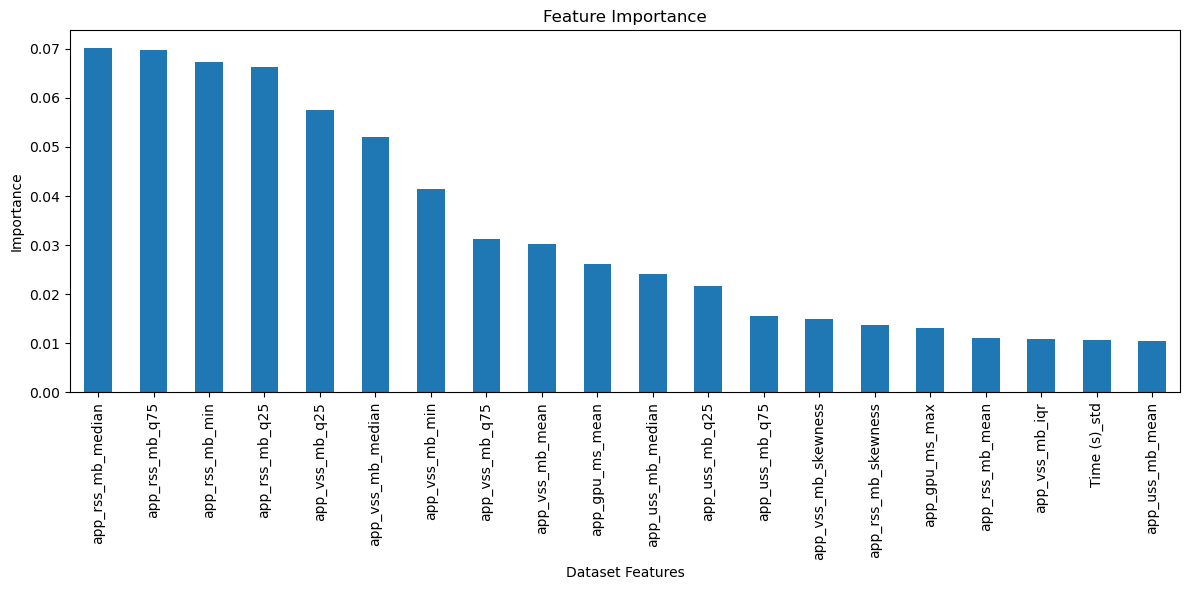

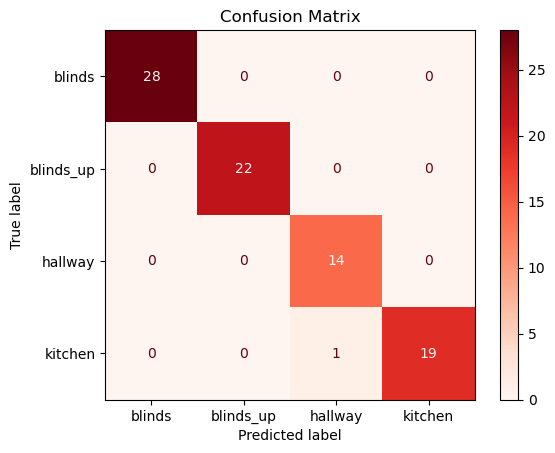

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# print feature importance
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
# plot a simple bar chart
feature_importances.head(20).plot.bar(figsize=(12, 6))
plt.title("Feature Importance")
plt.xlabel('Dataset Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# display a confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap="Reds")
plt.title("Confusion Matrix")
plt.show()